In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import os
import warnings
from micromlgen import port
import m2cgen as m2c
warnings.filterwarnings("ignore")

In [2]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [3]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def iq_processing(data):
    
    """
    Input: Data
    Output: Processed Data

    Processing: Power Scaling, IQ shifting
    """

    cols_real = ['pdda_input_real_{}'.format(x+1) for x in range(5)]
    cols_imag = ['pdda_input_imag_{}'.format(x+1) for x in range(5)]

    iq_values = pd.DataFrame(data['pdda_input_real'].tolist(), columns=cols_real, index=data.index)
    iq_values[cols_imag] = pd.DataFrame(data['pdda_input_imag'].tolist(), columns=cols_imag, index=data.index)
    
    phase = pd.DataFrame(np.arctan2(iq_values['pdda_input_imag_1'],iq_values['pdda_input_real_1']), columns=['phase_1'])
    
    cos = np.cos(phase).values.ravel()
    sin = np.sin(phase).values.ravel()
    
    out = data.copy()
    iq_ref = np.abs(iq_values[f'pdda_input_real_1']*cos + iq_values[f'pdda_input_imag_1']*sin)
    for i in range(1,6):
        out[f'pdda_input_real_{i}'] = (iq_values[f'pdda_input_real_{i}']*cos + iq_values[f'pdda_input_imag_{i}']*sin)
        out[f'pdda_input_imag_{i}'] = (-iq_values[f'pdda_input_real_{i}']*sin + iq_values[f'pdda_input_imag_{i}']*cos)
        iq_ref +=  iq_values[f'pdda_input_real_{i}']**2 + iq_values[f'pdda_input_imag_{i}']**2

    power_norm =  StandardScaler().fit_transform((out['reference_power'] + out['relative_power']).values.reshape(-1,1))/10
    
    out.insert(25, 'power', power_norm)
    out.insert(24, 'iq_ref', iq_ref)
    out.drop(columns=['pdda_input_imag_1', 'pdda_input_real', 'pdda_input_imag'], inplace=True)
    return out

In [5]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']
point = ['point']

In [6]:
new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']

In [7]:
def scale(df):
    """scale dataset with mean=0, std=1"""
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

In [8]:
def select_polarity(df):
    """"rssi signals closer to 0, represent the better quality of signal"""
    tmp = df.sort_values(['point', 'anchor', 'channel', 'room'])
    tmp['mask'] = tmp['reference_power'] + df['relative_power']
    tmp = tmp.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
    tmp = tmp.drop_duplicates(subset=['point', 'anchor', 'channel', 'room'], keep='last')
    return tmp

In [9]:
def train(df, models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_loc = []
    y_loc = []
    pts = []
    flag = True
    trained_models = {}
    anchor_mae = {}
    pdda_error = []
    m_preds = {}
    for model in models:
        print(str(model))
        for anchor in [1.0,2.0,3.0,4.0]:
            avg_mae = 0
            avg_pdda = 0
            anchor_df = df.loc[df['anchor'] == anchor]
            X = anchor_df[new_features].values
            y = anchor_df[targets].values
            gss = GroupShuffleSplit(n_splits=params["splits"], test_size=params["test_size"], random_state=params["random_state"])
            fold = 1
            for train_idx, test_idx in gss.split(X, y, groups=anchor_df.point):
                temp = pd.DataFrame()
                train = anchor_df.iloc[train_idx]
                test = anchor_df.iloc[test_idx]
                assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
                assert len(set(train.point) & set(test.point)) == 0
                X_train = train[new_features].values
                y_train = train[targets].values
                X_test = test[new_features].values
                test_location = test[location].values
                pdda_result = test[pdda_angle].values
                y_test = test[targets].values
                points = test[point].values
                

                # learn the trainer on the train set and apply for testing set
                regr = model
                regr.fit(X_train,y_train)
                if str(model) not in trained_models:
                    if str(model).split("(")[0] != "XGBRegressor":
                        trained_models[str(model)] = regr
                    else:
                        trained_models["XGBRegressor"] = regr
                # trained_models.append(regr)
                predictions = regr.predict(X_test)
                # print(predictions)
    
                # need pointwise error for plotting using spatial_plot function
                for i in range(len(predictions)):
                    model_preds.append(predictions[i])
                    # predictions.append(mean_absolute_error(y_test[i], temp))
                    pdda_preds.append(pdda_result[i][0])
                    true_phi.append(y_test[i][0])
                    pts.append(points[i][0])
                    x_coordinate, y_coordinate = test_location[i]
                    x_loc.append(x_coordinate)
                    y_loc.append(y_coordinate)
                    anchor_val.append(anchor)
                l_mae = mean_absolute_error(y_test.ravel(), predictions.ravel())
                pdda_mae = mean_absolute_error(y_test.ravel(), pdda_result.ravel())
                avg_mae += l_mae
                avg_pdda += pdda_mae
               
        
                # print(avg_mae)
            avg_mae = avg_mae/3
            avg_pdda = avg_pdda/3
            # print(avg_mae)
            if len(pdda_error) < 4:
                pdda_error.append(avg_pdda)
            model_name = str(model).split("(")[0]
            if model_name != 'XGBRegressor':
                model_name = str(model)
            if str(model_name) not in anchor_mae:
                anchor_mae[model_name] = [avg_mae]
            else:
                anchor_mae[model_name] += [avg_mae]
            # avg_mae.append(sum(errors)/len(errors))
            # temp = []

        
        
        # model_name = str(model).split("(")[0]
        # if model_name == 'XGBRegressor':
        #     results[model_name] = model_preds
        # else:
        #     results[str(model)] = model_preds
         
        if flag:
            temp['pdda'] = pdda_preds
            temp['true_phi'] = true_phi
            temp['x_loc'] = x_loc
            temp['y_loc'] = y_loc
            temp['point'] = pts
            temp['anchor'] = anchor_val
            results = pd.concat([results, temp])
            flag = False
            
        model_name = str(model).split("(")[0]
        if model_name != 'XGBRegressor':
            model_name = str(model)
        m_preds[model_name] = model_preds
        model_preds = []
        pdda_preds = []
        true_phi = []
        x_loc = []
        y_loc = []
        pts = []
        anchor_val = []
        # results = pd.concat([results, temp])
    for k,v in m_preds.items():
        results[k] = v
    return (results, anchor_mae, pdda_error, trained_models)

In [10]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_pdda = []
        maes_rf100 = []
        maes_rf10 = []
        maes_svr = []
        maes_lr = []
        
        maes_xgboost = []
        maes_dt = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

        maes_rf100.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_rf10.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor(n_estimators=10)'].values)], [tdf['true_phi'].values[0]]))
        maes_svr.append(mean_absolute_error([np.mean(tdf['SVR()'].values)], [tdf['true_phi'].values[0]]))
        maes_xgboost.append(mean_absolute_error([np.mean(tdf['XGBRegressor'].values)], [tdf['true_phi'].values[0]]))
        maes_dt.append(mean_absolute_error([np.mean(tdf['DecisionTreeRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_lr.append(mean_absolute_error([np.mean(tdf['LinearRegression()'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda
        p_df['MAE_LR'] = maes_lr
        p_df['MAE_SVR'] = maes_svr
        p_df['MAE_DT'] = maes_dt
        
        p_df['MAE_RF10'] = maes_rf10
        
        p_df['MAE_XGBoost'] = maes_xgboost

        p_df['MAE_RF100'] = maes_rf100
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [11]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10), DecisionTreeRegressor(), SVR(),
          xgb.XGBRegressor(),LinearRegression()]
metrics = [mean_absolute_error, r2_score]

In [82]:
result = pd.read_pickle('results/figure3_panel1.pkl')

In [84]:
result.head(10)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
pdda,8.543385,8.432292,9.389305,8.860607
Linear Regression,9.412078,9.568003,9.844010,10.268760
SVR,8.547875,8.643641,8.761621,9.003906
Decision Tree,6.882543,7.261287,7.606070,7.617472
RF10,5.611666,5.740991,6.253664,6.183317
XGBoost,5.643571,5.838038,6.218492,6.293050
RF100,5.413609,5.568117,5.972842,5.890732
aoanet,4.831005,4.991831,5.408162,5.551577
Modified aoanet,4.895520,5.168705,5.537297,5.588882


In [14]:

def all_environments():
    rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
    aoanet= [4.831005,4.991831,5.408162,5.551577]
    modified_aoanet = [4.895520,5.168705,5.537297,5.588882]
    result = pd.DataFrame()
    i = 0
    for room in rooms:
        environment = df[df['room'] == room]
        environment = iq_processing(environment)
        environment = scale(environment)
        environment = select_polarity(environment)
        environment = combine_features(environment)

        results, anchor_mae, pdda_error, trained_models = train(environment, models, metrics)

        avg_errors = calculate_mae_errors(results)

        col_names = ['MAE_pdda','MAE_LR', 'MAE_SVR', 'MAE_DT', 'MAE_RF10', 'MAE_XGBoost', 'MAE_RF100']
        model_names = ['pdda', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100','Modified AoANet','AoANet']

        result.index = model_names
        errors = list(avg_errors[col_names].mean().values)
        errors.append(modified_aoanet[i])
        errors.append(aoanet[i])
        result[room] = errors
        i += 1
    return result, trained_models
    

In [13]:
# cols = ['element1','element2','element3','element4','element5']

def combine_features(df):
    grouped = df.groupby(['room','anchor', 'point'],as_index=False)
    new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']
    x_loc = []
    y_loc = []
    pts = []
    pdda = []
    anchors = []
    pdda = []
    true_phi = []
    room = []
    combined_features = []
    temp = pd.DataFrame()
    for group, tdf in grouped:
        soi_matrix = tdf[features]
        # print(soi_matrix)
        soi_matrix = soi_matrix.values.reshape(1,30)
        # print(soi_matrix[0])
        # break
        x_loc.append(tdf['x_tag'].values[0])
        y_loc.append(tdf['y_tag'].values[0])
        pts.append(tdf['point'].values[0])
        anchors.append(tdf['anchor'].values[0])
        pdda.append(tdf['pdda_phi'].values[0])
        room.append(tdf['room'].values[0])
        combined_features.append(soi_matrix[0])
        true_phi.append(tdf['true_phi'].values[0])

    temp[new_features] = combined_features
    temp['true_phi'] = true_phi
    temp['pdda_phi'] = pdda
    temp['anchor'] = anchors
    temp['point'] = pts
    temp['x_tag'] = x_loc
    temp['y_tag'] = y_loc
    temp['room'] = room
    return temp

In [20]:
trained_models

{'RandomForestRegressor()': RandomForestRegressor(),
 'RandomForestRegressor(n_estimators=10)': RandomForestRegressor(n_estimators=10),
 'DecisionTreeRegressor()': DecisionTreeRegressor(),
 'SVR()': SVR(),
 'XGBRegressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, ...),
 'LinearRegression()': LinearRegression()}

In [33]:
booster = trained_models['XGBRegressor'].get_booster()
tree_df = booster.trees_to_dataframe()
# tree_df[tree_df['Tree'] == 0]

In [34]:
# import json
# def item_generator(json_input, lookup_key):
#     if isinstance(json_input, dict):
#         for k, v in json_input.items():
#             if k == lookup_key:
#                 yield v
#             else:
#                 yield from item_generator(v, lookup_key)
#     elif isinstance(json_input, list):
#         for item in json_input:
#             yield from item_generator(item, lookup_key)

# def tree_depth(json_text):
#     json_input = json.loads(json_text)
#     return max(list(item_generator(json_input, 'depth'))) + 1

# [tree_depth(x) for x in booster.get_dump(dump_format = "json")]

In [36]:
# avg_tree_depth = 0
# count = 0
# total = 0
# for estimator in trained_models['DecisionTreeRegressor()'].estimators_:
#     count += 1
#     total += estimator.tree_.max_depth
# total/count

In [15]:
result, trained_models = all_environments()

RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
SVR()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
LinearRegression()
RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
SVR()
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
  

In [101]:
# result.to_pickle('results/multichannel.pkl')

In [106]:
def stripplot():
    # aoanet= [4.831005,4.991831,5.408162,5.551577]
    result = pd.read_pickle('results/multichannel.pkl')
    # result = all_environments()
    result.rename(columns={'pdda': 'PDDA', 'aoanet': 'AoANet', 'Modified aoanet':'Modified AoANet'}, inplace=True)
    
    model_names = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'Modified AoANet','AoANet']
    result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100','Modified AoANet','AoANet']
    subset = result.loc[model_names]
    df_melted = subset.reset_index().melt(id_vars='index')
    df_melted = df_melted.rename(columns={'index': 'Model', 'value': 'MAE', 'variable':'Environment'})

    # figure 3
    data = result.loc[model_names]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15,8))
    plt.title('Average MAE for All Envirnments using 3 Channels')
    ax = sns.stripplot(data=df_melted, x='Model', y='MAE', hue='Environment', size=7)
    ax.set_ylim([4,10])
    plt.savefig('figures/Figure3/panel1/models_stripplot_multichannel.png')
    plt.savefig('figures/Figure3/panel1/models_stripplot_multichannel.pdf', bbox_inches='tight')

    plt.show()

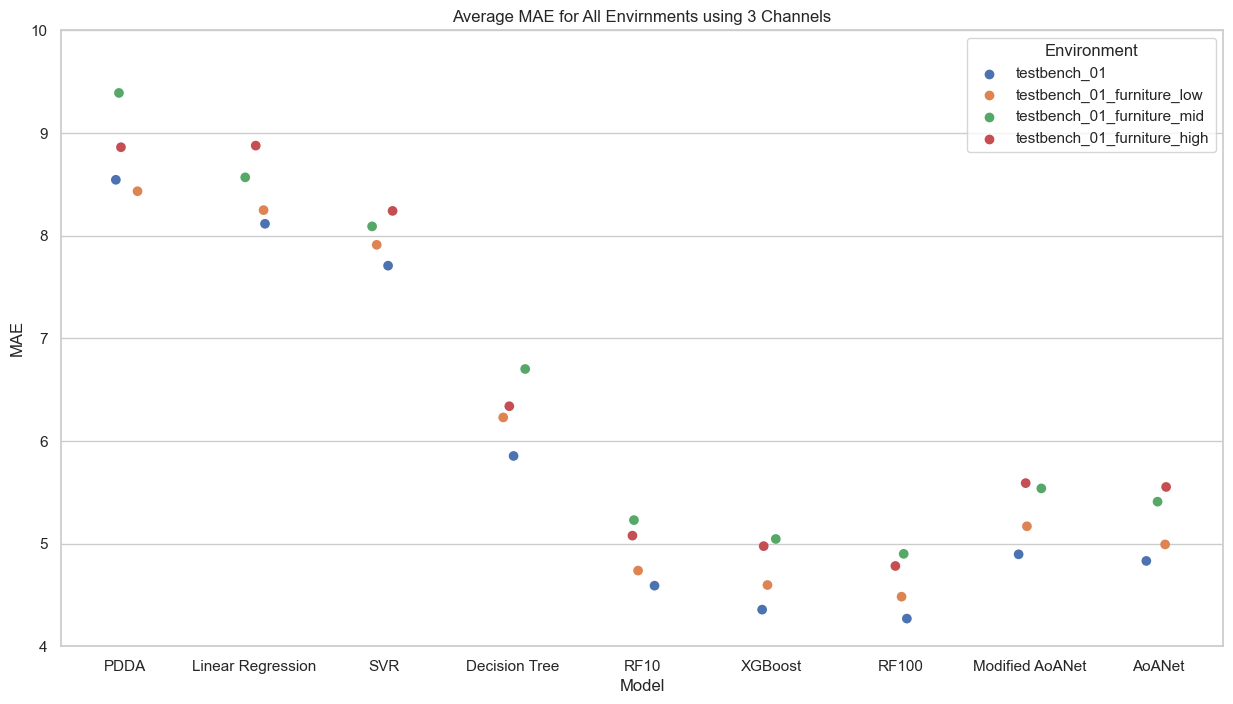

In [107]:
stripplot()

In [136]:
environment = df[df['room'] == 'testbench_01_furniture_mid']
environment = iq_processing(environment)
environment = scale(environment)
environment = select_polarity(environment)
environment = combine_features(environment)

results, anchor_mae, pdda_error, trained_models = train(environment, models, metrics)
        

RandomForestRegressor()


KeyboardInterrupt: 

In [118]:
environment[new_features].values[0]

array([-1.06498225, -1.02169505, -0.88210107,  0.36731684, -0.34239239,
        0.43721337, -0.24015097, -0.44909086,  0.0101671 , -0.67371197,
       -0.9594799 , -0.69148155, -0.46643819,  0.12041559,  0.08175228,
        0.09414331, -0.08858204, -0.2395787 ,  0.37089802, -0.30053167,
       -0.90672872, -0.53291384, -0.4952998 ,  0.15463726, -0.11381661,
        0.10600844, -0.53721834, -0.38098864, -0.16580797,  0.08724365])

In [119]:
environment['true_phi'].values[0]

45.0

In [125]:
trained_models['XGBRegressor'].predict(environment[new_features])

array([-16.090067, -31.970781, -34.043396, ..., -19.799982, -20.136278,
       -19.16629 ], dtype=float32)

In [113]:
import sys

sys.setrecursionlimit(2147483647)

In [114]:
def convert_models(trained_models):
    
    for model_name,model in trained_models.items():
        try:
            code = m2c.export_to_c(model)
            with open('converted_models/multichannel/'+model_name+'.h', 'w') as file:
                # file.write(port(model))
                 file.write(code)
        except Exception as e:
            print("could not convert "+model_name)
            print(e)

In [115]:
convert_models(trained_models)

In [1]:
model_sizes = {"RF100": (1490000-166968) * (2**(-10)), "RF10": (591888-166968) * (2**(-10)), "Decision Tree":  (233480-166968) * (2**(-10)) , 
               "Linear Regression": (169584-166968) * (2**(-10))+10, "SVR": (1050000-166968) * (2**(-10)), "XGBoost": (351552-166968)* (2**(-10)), 
               "AoANet": 1650, "Modified AoANet":1035716*(2**(-10))}


In [2]:
multichannel_model_sizes = {'XGBoost': 180.140625,
 'RF10': 414.84375,
 'Decision Tree': 65.984375,
 'Linear Regression': 2.5546875,
 'SVR': 2520.5390625,
 'RF100': 2908.9453125,
 'AoANet': 2097.93359375,
 'Modified AoANet': 848.38671875}

In [57]:
multichannel_model_sizes

{'XGBoost': 180.140625,
 'RF10': 414.84375,
 'Decision Tree': 65.984375,
 'Linear Regression': 11.4,
 'SVR': 1600,
 'RF100': 1650.5,
 'AoANet': 1550,
 'Modified AoANet': 848.38671875}

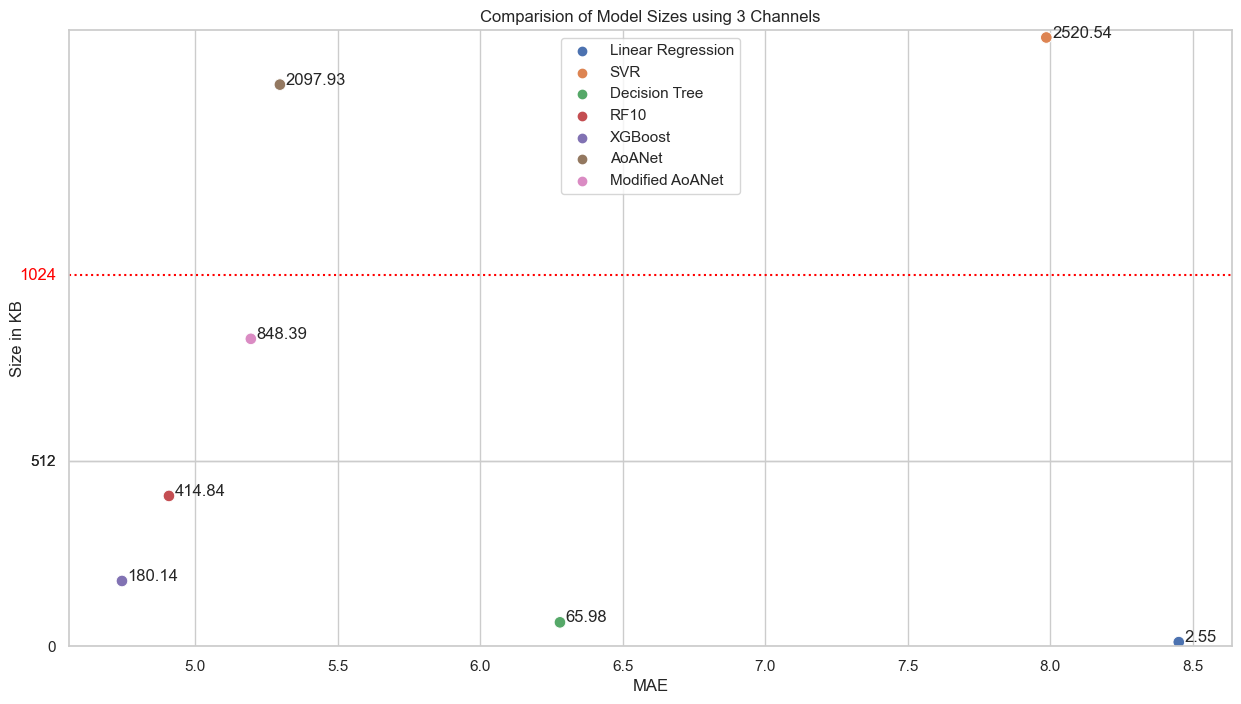

In [87]:
plt.close()
multichannel_model_sizes = {'XGBoost': 180.140625,
 'RF10': 414.84375,
 'Decision Tree': 65.984375,
 'Linear Regression': 11.4,
 'SVR': 1680,
 # 'RF100': 1650.5,
 'AoANet': 1550,
 'Modified AoANet': 848.38671875}

result = pd.read_pickle('results/multichannel.pkl')
result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'AoANet','Modified AoANet']
    
# 1266676 *(2**(-10))+ 1024
# model_sizes = {"RF100": 1490000 * (2**(-10)), "RF10": 504408 * (2**(-10)), "Decision Tree":  62168 * 0.001, "Linear Regression": 1672 * (2**(-10))+10, "SVR": 1050000 * (2**(-10)), "XGBoost": 183320* (2**(-10)), "AoANet": 1650, "Modified AoANet":1035716*(2**(-10))}
model_sizes = multichannel_model_sizes
data = pd.DataFrame.from_dict(model_sizes, orient="index")
temp = pd.DataFrame()
temp['MAE'] = result.mean(axis=1)
merged = pd.concat([temp,data], axis=1)
merged.reset_index(inplace=True)
merged.columns = ["Model","MAE", "Size in KB"]
merged = merged[merged['Size in KB'].notna()]
import matplotlib.transforms as transforms
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=merged, y="Size in KB", x="MAE", hue ='Model',s=70)
plt.axhline(y=1024, linestyle=':', color='red')
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,1024, "{:.0f}".format(1024), color="red", transform=trans, 
        ha="right", va="center")

ax.set_ylim(0, 1700)
# plt.ylim(left=0)

plt.yticks([0,  512, 512])
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if 1650 <= point['y'] < 1651:
            print('a')
            # point['val'] = 35.23
            # print(point['y'])
            # ax.text(point['x']+.02, 1650, '{0}'.format((2260)))
        elif 11 <= point['y'] < 12:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format(2.55))
        elif 1680 <= point['y'] < 1681:
            ax.text(point['x']+.02, 1680, '{0:.2f}'.format(2520.5390625))
        elif 1550 <= point['y'] < 1551:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format(2097.93359375))
        else:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format((point['val'])))

label_point(merged["MAE"], merged["Size in KB"], merged["Size in KB"], ax)
plt.legend(loc='upper center')
plt.title('Comparision of Model Sizes using 3 Channels')
# ax.set_ylim(bottom=None, top=7)
# plt.ylim(0,1.6)
plt.savefig("figures/sizes/multi_size_performace_multi.pdf", bbox_inches='tight')
plt.savefig('figures/sizes/multi_size_performace_multi.png',format="png")
plt.show()

In [ ]:
model_sizes = {"RF100": (1490000-166968) * (2**(-10)), "RF10": (642872-166968) * (2**(-10)), "Decision Tree":  (235992-166968) * (2**(-10)) , 
               "Linear Regression": (169584-166968) * (2**(-10))+10, "SVR": (1050000-166968) * (2**(-10)), "XGBoost": (344456-166968)* (2**(-10)), 
               "AoANet": 1650, "Modified AoANet":1035716*(2**(-10))}

In [19]:
base = 166968

In [59]:
multichannel_model_sizes = {
    "XGBoost":351432,
    "RF10": 591768,
    "Decision Tree":234536,
    "Linear Regression":169584,
    "SVR":1699424+1048576,
    "RF100":3*1048576,
    "AoANet":1266676 +1048576,
    "Modified AoANet":1035716,
}

In [29]:
singlechannel_model_sizes = {
    "XGBoost":344456,
    "RF10": 594216,
    "Decision Tree":219416,
    "Linear Regression":168664,
    "SVR":955816,
    "RF100": 3*1048576,
}

In [30]:
for k,v in singlechannel_model_sizes.items():
    singlechannel_model_sizes[k] = (v-base) *(2**(-10))

In [46]:
singlechannel_model_sizes

{'XGBoost': 173.328125,
 'RF10': 417.234375,
 'Decision Tree': 51.21875,
 'Linear Regression': 11,
 'SVR': 770.359375,
 'PDDA': 35.21484375}

In [88]:
singlechannel_model_sizes

{'XGBoost': 173.328125,
 'RF10': 417.234375,
 'Decision Tree': 51.21875,
 'Linear Regression': 11,
 'SVR': 770.359375,
 'PDDA': 35.21484375,
 'RF100': 1650}

In [45]:
singlechannel_model_sizes['PDDA'] = 36060*(2**(-10))

In [89]:
del singlechannel_model_sizes['RF100']

In [48]:
singlechannel_model_sizes['Linear Regression'] = 11
singlechannel_model_sizes['RF100'] = 1650

In [61]:
multichannel_model_sizes

{'XGBoost': 180.140625,
 'RF10': 414.84375,
 'Decision Tree': 65.984375,
 'Linear Regression': 2.5546875,
 'SVR': 2520.5390625,
 'RF100': 2908.9453125,
 'AoANet': 2097.93359375,
 'Modified AoANet': 848.38671875}

In [60]:
for k,v in multichannel_model_sizes.items():
    multichannel_model_sizes[k] = (v-base) *(2**(-10))

In [12]:
model_sizes = singlechannel_model_sizes

In [177]:
model_sizes = {'XGBoost': 173.328125,
 'RF10': 417.234375,
 'Decision Tree': 51.21875,
 'Linear Regression': 11.65625,
 'SVR': 770.359375,
 'RF100': 1650}

gela


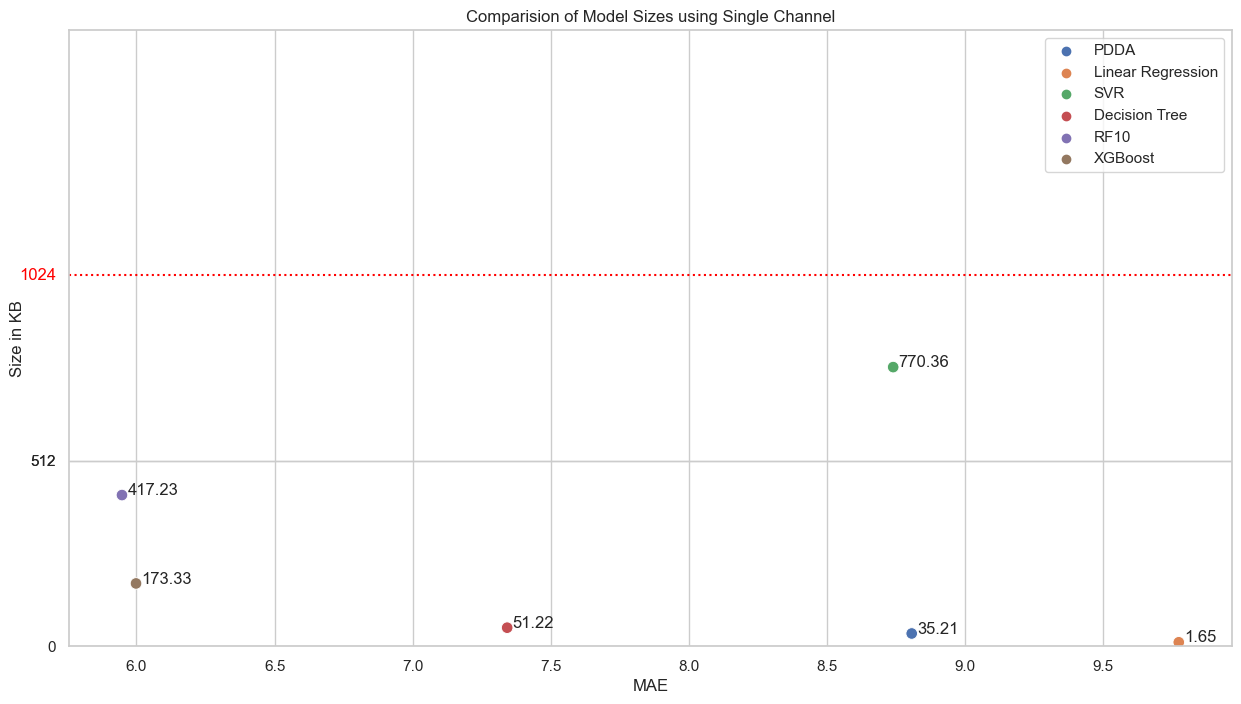

In [90]:
plt.close()
result = pd.read_pickle('results/figure3_panel1.pkl')
result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'AoANet','Modified AoANet']
    
# 1266676 *(2**(-10))+ 1024
model_sizes = singlechannel_model_sizes
data = pd.DataFrame.from_dict(model_sizes, orient="index")
temp = pd.DataFrame()
temp['MAE'] = result.mean(axis=1)
merged = pd.concat([temp,data], axis=1)
merged.reset_index(inplace=True)
merged.columns = ["Model","MAE", "Size in KB"]
merged = merged[merged['Size in KB'].notna()]
import matplotlib.transforms as transforms
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=merged, y="Size in KB", x="MAE", hue ='Model',s=70)
plt.axhline(y=1024, linestyle=':', color='red')
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,1024, "{:.0f}".format(1024), color="red", transform=trans, 
        ha="right", va="center")

ax.set_ylim(0, 1700)
# plt.ylim(left=0)

plt.yticks([0,  512, 512])
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        # print(point['y'] )
        if 1650 <= point['y'] < 1651:
            print('a')
            point['val'] = 35.23
            print(point['y'])
            ax.text(point['x']+.02, 1650, '{0}'.format((2260)))
        elif 11 <= point['y'] < 12:
            print('gela')
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format(1.65))
        else:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format((point['val'])))

label_point(merged["MAE"], merged["Size in KB"], merged["Size in KB"], ax)
plt.legend(loc='upper right')
plt.title('Comparision of Model Sizes using Single Channel')
# ax.set_ylim(bottom=None, top=7)
# plt.ylim(0,1.6)
plt.savefig("figures/sizes/single_size_performace.pdf", bbox_inches='tight')
plt.savefig('figures/sizes/single_size_performace.png',format="png")
plt.show()